In [1]:
%load_ext autoreload
import ddls

Initialise what type(s) of nodes (servers) you want in your cluster and what type(s) of worker(s) you want to populate them with.

In [19]:
%autoreload
from ddls.devices.processors.gpus.A100 import A100

node_config = {'type_1':
                  {
                      'num_nodes': 16,
                      'workers_config': 
                          [
                              {
                               'num_workers': 4,
                               'worker': A100
                              }
                          ]
                  }
              }

print(node_config)

{'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 4, 'worker': <class 'ddls.devices.processors.gpus.A100.A100'>}]}}


Initialise the topology to be populated by your nodes.

In [20]:
topology_config = {'type':
                      'torus',
                   'kwargs':
                      {
                          'x_dims': 4,
                          'y_dims': 4
                      }
                  }

Initialise the cluster environment using your node and topology configuration.

Cluster <class 'ddls.environments.cluster.cluster_environment.ClusterEnvironment'> | Topology: <class 'ddls.topologies.torus.Torus'> with 16 nodes and 32 | Topology config: {'type': 'torus', 'kwargs': {'x_dims': 4, 'y_dims': 4}} | Node config: {'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 4, 'worker': <class 'ddls.devices.processors.gpus.A100.A100'>}]}}


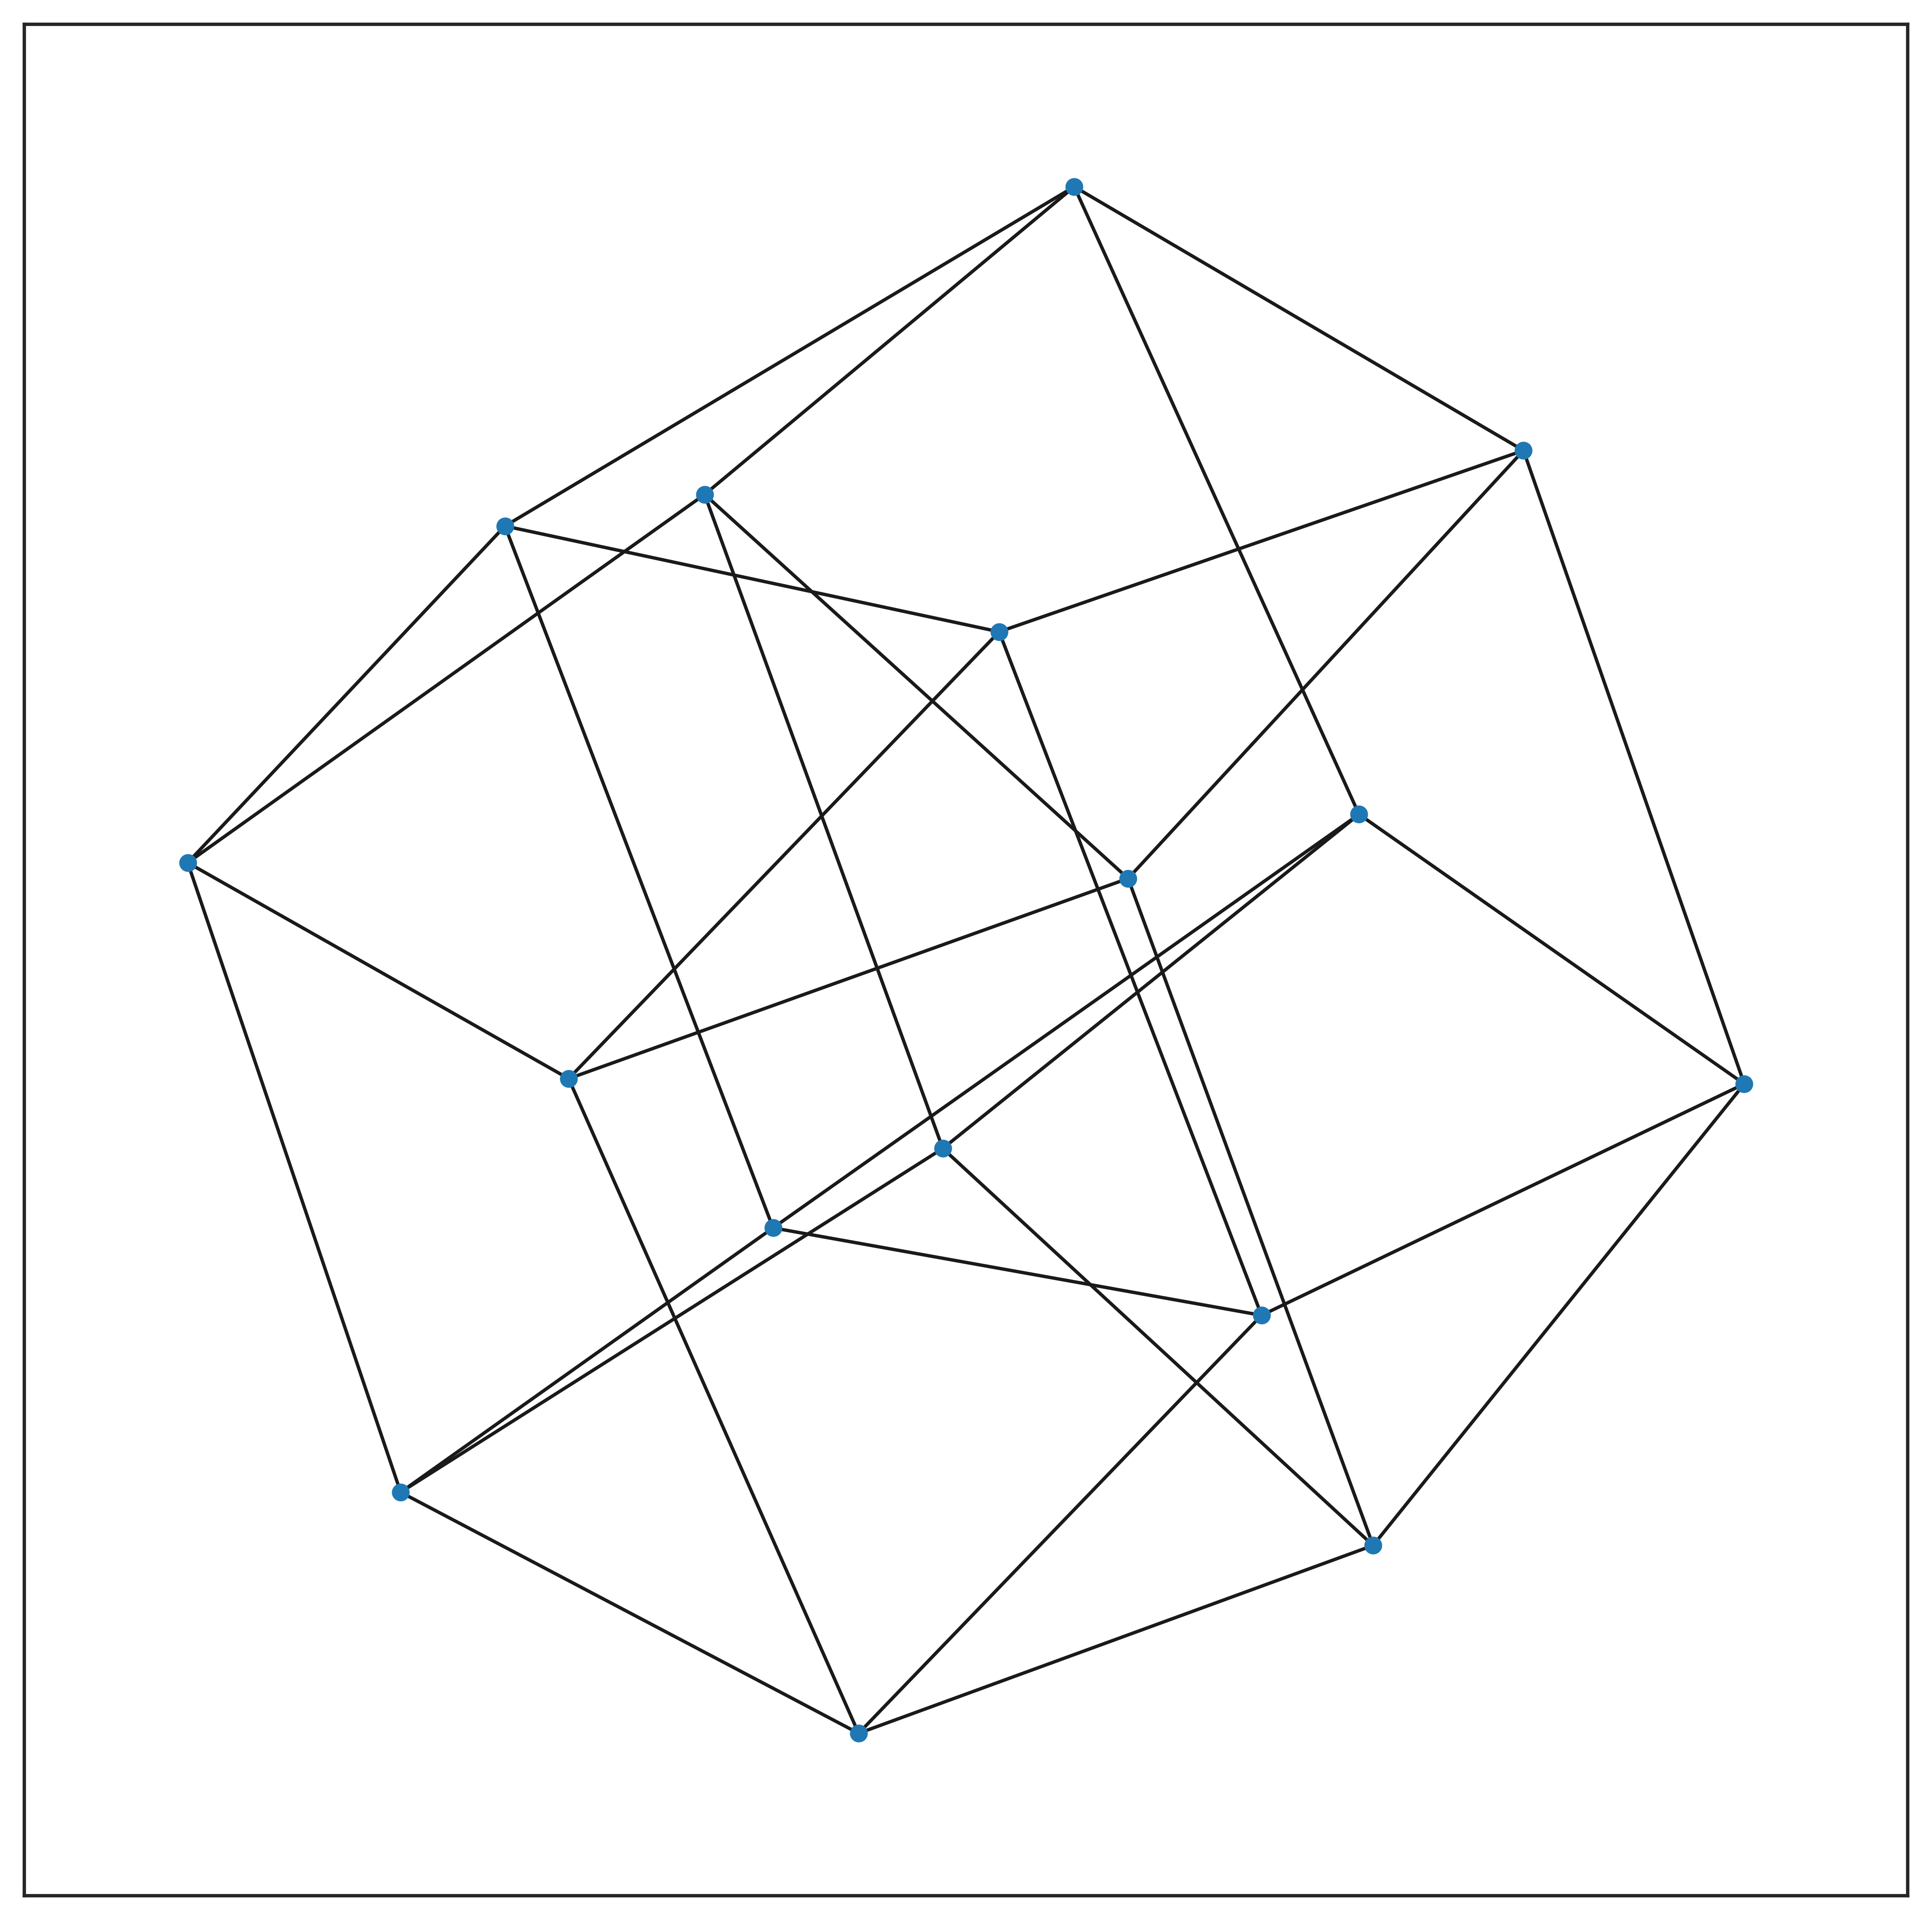

Node 1-1-1: {'workers': {140439300495536: <ddls.devices.processors.gpus.A100.A100 object at 0x7fba929e58b0>, 140439300493664: <ddls.devices.processors.gpus.A100.A100 object at 0x7fba929e5160>, 140439300497216: <ddls.devices.processors.gpus.A100.A100 object at 0x7fba929e5f40>, 140439300494288: <ddls.devices.processors.gpus.A100.A100 object at 0x7fba929e53d0>}}
Node 2-1-1: {'workers': {140439300494576: <ddls.devices.processors.gpus.A100.A100 object at 0x7fba929e54f0>, 140439160959904: <ddls.devices.processors.gpus.A100.A100 object at 0x7fba8a4d33a0>, 140439300496304: <ddls.devices.processors.gpus.A100.A100 object at 0x7fba929e5bb0>, 140439300496448: <ddls.devices.processors.gpus.A100.A100 object at 0x7fba929e5c40>}}
Node 3-1-1: {'workers': {140439300496880: <ddls.devices.processors.gpus.A100.A100 object at 0x7fba929e5df0>, 140439300496592: <ddls.devices.processors.gpus.A100.A100 object at 0x7fba929e5cd0>, 140439300494336: <ddls.devices.processors.gpus.A100.A100 object at 0x7fba929e5400>,

In [21]:
%autoreload
from ddls.environments.cluster.cluster_environment import ClusterEnvironment

env = ClusterEnvironment(topology_config=topology_config,
                          node_config=node_config,
                          path_to_save='/scratch/datasets/ddls/sims',
                          save_freq=100,
                          use_sqlite_database=True)
print(env)
env.topology.render()

for node in env.topology.graph:
    print(f'Node {node}: {env.topology.graph.nodes[node]}')

Load the `ddls` computation graph(s) you want to run on the cluster.

In [22]:
%autoreload
from ddls.utils import ddls_graph_from_pbtxt_file
from ddls.plotting.plotting import plot_computation_graph

import glob


# get file paths
path_to_files = '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid'
file_paths = glob.glob(path_to_files + '/*')
    
# create ddls graph
num_graphs = 2
ddls_computation_graphs = [ddls_graph_from_pbtxt_file(file_path, processor_type_profiled='A100', verbose=False) for file_path in file_paths[:num_graphs]]

# visualise
visualise = False
if visualise:
    for graph in ddls_computation_graphs:
        fig = plot_computation_graph(graph, scaling_factor=3, title='ddls_graph', show_fig=True, verbose=True)

Initialise `ddls` job(s) from the computation graph(s)

In [23]:
%autoreload
from ddls.demands.jobs.job import Job

jobs = [Job(computation_graph=graph, num_training_steps=2) for graph in ddls_computation_graphs]

for job in jobs:
    print(job)

Job ID: 140440078570880 | # nodes: 96 | # edges: 410 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 13897
Job ID: 140439177816768 | # nodes: 68 | # edges: 128 | # training steps: 2 | Total op mem cost: 0 | Total dep size: 4059


Initialise an operation placement agent.

In [24]:
%autoreload
from ddls.managers.placers.random_job_placer import RandomJobPlacer
from ddls.managers.schedulers.srpt_job_scheduler import SRPTJobScheduler

control_plane = {
    'job_placer': RandomJobPlacer(),
    'job_scheduler': SRPTJobScheduler()
}

Reset cluster environment and run `Cluster`

In [25]:
%autoreload
from ddls.distributions.uniform import Uniform
from ddls.utils import seed_stochastic_modules_globally

import time
import pprint


# seeds = [0, 1, 2]
seeds = [0]
verbose = True

for seed in seeds:
    print(f'\n\n\n~~~~~~~~~~~~~~~~~~~~~~~ Seed {seed} ~~~~~~~~~~~~~~~~~~~~~~~')
    seed_stochastic_modules_globally(seed)
    obs, action_set, reward, done, info = env.reset(jobs=jobs,
                                                    job_sampling_mode='remove',
                                                    job_interarrival_time_dist=Uniform(min_val=1, max_val=1000),
                                                    max_simulation_run_time=float('inf'),
                                                    job_queue_capacity=10,
                                                    seed=seed,
                                                    verbose=True)
    
    start_time = time.time()
    while not done:
        # make decisions
        actions = {}
        actions['job_placement'] = control_plane['job_placer'].get_placement(cluster=env)
        actions['job_schedule'] = control_plane['job_scheduler'].get_schedule(new_placements=actions['job_placement'], cluster=env)

        # pass actions to cluster environment and step the cluster
        obs, action_set, reward, done, info = env.step(actions, verbose=verbose)
        if not verbose:
            print(f'Step {env.step_counter} | Jobs arrived: {env.num_jobs_arrived} | completed: {len(env.jobs_completed)} | blocked: {len(env.jobs_blocked)} | running: {len(env.jobs_running)} | queued: {len(env.job_queue)}')
    
    print(f'\nCompleted simulation in {time.time() - start_time:.3f} s')




~~~~~~~~~~~~~~~~~~~~~~~ Seed 0 ~~~~~~~~~~~~~~~~~~~~~~~
Initialised folder /scratch/datasets/ddls/sims/cluster/cluster_43/reset_1
Reset cluster environment.
Job interarrival time dist: Distribution type: <class 'ddls.distributions.uniform.Uniform'> | min_val: 1 | max_val: 1000 | interval: 1 | decimals: 10
Job sampler: Original pool length: 2 | Current pool length: 1 | Sampling mode: remove
Max sim run time: inf
Step 1 | Jobs arrived: 2 | completed: 0 | blocked: 0 | running: 1 | queued: 1
Step 2 | Jobs arrived: 2 | completed: 1 | blocked: 0 | running: 1 | queued: 0
Saved logs to /scratch/datasets/ddls/sims/cluster/cluster_43/reset_1/ in 0.2644 s.
Step 3 | Jobs arrived: 2 | completed: 2 | blocked: 0 | running: 0 | queued: 0

Completed simulation in 0.345 s


**TODO**: Implement logic for placing job ops of each job -> step env -> time job completion for 1 training step (can then think about $n$ training steps, network communication overhead, etc.)

- Have mounted job onto devices
- Now need to work out way of tracking ops running on each device efficiently and timing how long they take. Consider having global dict tracking operations which are running to avoid having to keep looping through all ops to check dependencies. Consider also having stopwatch object similar to Noah's where only tick it when have stacked enough sequential operations. N.B. Think should assume that, once ops have been placed on a device, they must be ran sequentially (i.e. cannot run multiple ops on one device at the same time; assume time profile is for e.g. GPU worker running just that one op with <= all its cores)